In [184]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, variance
from pyspark.sql import SparkSession, DataFrame

from pyspark.ml import Pipeline
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.regression import GeneralizedLinearRegression, GBTRegressor
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

In [2]:
sp = (
    SparkSession
    .builder.appName("Model")
    .config("spark.sql.session.timeZone", "-04")
    #.config("spark.sql.repl.eagerEval.enabled", True)
    #.config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)
sp

22/08/25 22:08:25 WARN Utils: Your hostname, J-L resolves to a loopback address: 127.0.1.1; using 172.28.49.50 instead (on interface eth0)
22/08/25 22:08:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/25 22:08:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Load data

In [3]:
data = sp.read.parquet("../data/processed/merged/").drop("day", "count_taxis", "count_bikes", "trip_duration_taxis", "trip_duration_bikes")
# Retaining year for now to split train-test later
data.show(3)

+----+-----+--------+------------+------------+-----------+---------------+----------+---------------+------------------+-----------+---------+--------+----------+---------+--------+-------------+
|year|month|time_bin|PULocationID|DOLocationID|day_of_week|trip_difference|peak_hours|weather_pattern|better_travel_type|Temperature|Dew Point|Humidity|Wind Speed|Wind Gust|Pressure|Precipitation|
+----+-----+--------+------------+------------+-----------+---------------+----------+---------------+------------------+-----------+---------+--------+----------+---------+--------+-------------+
|2020|    7|       0|         113|          68|          4|           -206|         0|              1|                 0|       70.0|     65.0|    84.0|       6.0|      0.0|    29.9|          0.0|
|2020|    7|       0|         113|          68|          4|           -209|         0|              1|                 0|       70.0|     65.0|    84.0|       6.0|      0.0|    29.9|          0.0|
|2020|    7|   

### Feature Relevance

In [90]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [93]:
data_copy = data.sample(0.05).toPandas().copy()

In [94]:
data_copy.columns

Index(['year', 'month', 'time_bin', 'PULocationID', 'DOLocationID',
       'day_of_week', 'trip_difference', 'peak_hours', 'weather_pattern',
       'better_travel_type', 'Temperature', 'Dew Point', 'Humidity',
       'Wind Speed', 'Wind Gust', 'Pressure', 'Precipitation'],
      dtype='object')

In [95]:
data_copy.columns = ['year', 'month', 'time_bin', 'PULocationID', 'DOLocationID',
       'day_of_week', 'trip_difference', 'peak_hours', 'weather_pattern',
       'better_travel_type', 'Temperature', 'Dew_Point', 'Humidity',
       'Wind_Speed', 'Wind_Gust', 'Pressure', 'Precipitation'
]

In [96]:
model1 = ols("trip_difference ~ Temperature + Dew_Point + Humidity + Wind_Speed + Wind_Gust + Pressure + Precipitation", data=data_copy).fit()

aov_table1 = sm.stats.anova_lm(model1, typ=2)
print(aov_table1)

                     sum_sq        df           F        PR(>F)
Temperature    4.748266e+07       1.0  122.604773  1.716126e-28
Dew_Point      2.293416e+06       1.0    5.921820  1.495488e-02
Humidity       6.321189e+06       1.0   16.321916  5.345100e-05
Wind_Speed     7.405897e+07       1.0  191.227361  1.750626e-43
Wind_Gust      7.934770e+07       1.0  204.883369  1.837754e-46
Pressure       2.572316e+06       1.0    6.641968  9.960697e-03
Precipitation  1.824612e+05       1.0    0.471132  4.924670e-01
Residual       1.772270e+11  457617.0         NaN           NaN


### Classifier model

Working with a classifier first so we will drop the regression data. (Also drop null value if any as a safety check)

- Keep in mind, test data is still a part of the dataframe. We will ensure to use the same labels for all columns before we split and normalize the data

In [4]:
data_class = data.drop("trip_difference").dropna()
data_class.show(1)

+----+-----+--------+------------+------------+-----------+----------+---------------+------------------+-----------+---------+--------+----------+---------+--------+-------------+
|year|month|time_bin|PULocationID|DOLocationID|day_of_week|peak_hours|weather_pattern|better_travel_type|Temperature|Dew Point|Humidity|Wind Speed|Wind Gust|Pressure|Precipitation|
+----+-----+--------+------------+------------+-----------+----------+---------------+------------------+-----------+---------+--------+----------+---------+--------+-------------+
|2020|    7|       0|         113|          68|          4|         0|              1|                 0|       70.0|     65.0|    84.0|       6.0|      0.0|    29.9|          0.0|
+----+-----+--------+------------+------------+-----------+----------+---------------+------------------+-----------+---------+--------+----------+---------+--------+-------------+
only showing top 1 row



In [5]:
data_class.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- time_bin: integer (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- peak_hours: integer (nullable = true)
 |-- weather_pattern: integer (nullable = true)
 |-- better_travel_type: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Dew Point: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind Speed: double (nullable = true)
 |-- Wind Gust: double (nullable = true)
 |-- Pressure: double (nullable = true)
 |-- Precipitation: double (nullable = true)



In [6]:
data_class.groupBy("better_travel_type").count().show()

+------------------+-------+
|better_travel_type|  count|
+------------------+-------+
|                 1|4147790|
|                 0|5000914|
+------------------+-------+



In [7]:
def preprocessing_pipe(data: DataFrame, outcome: str):
    """
    Function to act as a pipeline to process and feed the model in vectorized format
    """
    # List of categorical columns
    categories = ["month", "time_bin", "PULocationID", "DOLocationID", "day_of_week", "weather_pattern"]

    # Pipeline
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index") for c in categories]
    encoders = [OneHotEncoder(inputCol=c+"_index", outputCol=c+"_encoded") for c in categories]
    transformed = Pipeline(stages=indexers + encoders).fit(data).transform(data)

    # Drop columns
    for c in categories:
        if c == "month":
            transformed = transformed.drop(c+"_index")
        else:
            transformed = transformed.drop(c).drop(c+"_index")
    return transformed

    assembled = VectorAssembler(
        inputCols= [c for c in transformed.drop("year", outcome).columns if not (c in categories) and not ("_index" in c)],
        outputCol="features"
    ).transform(transformed)
    
    return assembled.withColumnRenamed(outcome, "label")

In [8]:
data_class_transformed = preprocessing_pipe(data_class.dropna(), "better_travel_type")
data_class_transformed.show(1)

+----+-----+----------+------------------+-----------+---------+--------+----------+---------+--------+-------------+--------------+----------------+--------------------+--------------------+-------------------+-----------------------+
|year|month|peak_hours|better_travel_type|Temperature|Dew Point|Humidity|Wind Speed|Wind Gust|Pressure|Precipitation| month_encoded|time_bin_encoded|PULocationID_encoded|DOLocationID_encoded|day_of_week_encoded|weather_pattern_encoded|
+----+-----+----------+------------------+-----------+---------+--------+----------+---------+--------+-------------+--------------+----------------+--------------------+--------------------+-------------------+-----------------------+
|2020|    7|         0|                 0|       70.0|     65.0|    84.0|       6.0|      0.0|    29.9|          0.0|(11,[5],[1.0])| (23,[22],[1.0])|      (59,[6],[1.0])|      (59,[1],[1.0])|      (4,[2],[1.0])|          (2,[1],[1.0])|
+----+-----+----------+------------------+-----------+--

#### Split train, validation and test sets

Also drop year and month as we want to generalize for every year, and month has been from the assembler

In [9]:
X_test_class = data_class_transformed.filter(col("year") == 2022).drop("year", "month")
X_val_class = data_class_transformed.filter((col("year") == 2021) & (col("month") > 8)).drop("year", "month")
X_train_class = data_class_transformed.filter((col("year") == 2020) | ((col("month") < 9) & (col("year") == 2021))).drop("year", "month")

X_train_class.head(1)

[Row(peak_hours=0, better_travel_type=0, Temperature=70.0, Dew Point=65.0, Humidity=84.0, Wind Speed=6.0, Wind Gust=0.0, Pressure=29.9, Precipitation=0.0, month_encoded=SparseVector(11, {5: 1.0}), time_bin_encoded=SparseVector(23, {22: 1.0}), PULocationID_encoded=SparseVector(59, {6: 1.0}), DOLocationID_encoded=SparseVector(59, {1: 1.0}), day_of_week_encoded=SparseVector(4, {2: 1.0}), weather_pattern_encoded=SparseVector(2, {1: 1.0}))]

Process numerical types seperately

In [10]:
def process_numerical(data: DataFrame):
    """
    Function to scale and process numerical columns
    """
    # Scaler
    columns = ["Temperature", "Dew Point", "Humidity", "Wind Speed", "Wind Gust", "Pressure", "Precipitation"]

    va = VectorAssembler(inputCols=columns, outputCol="to_scale")
    sc = StandardScaler(inputCol="to_scale", outputCol="scaled")

    va_data = va.transform(data)
    data = sc.fit(va_data).transform(va_data)
    # Drop other columns
    for c in columns:
        data = data.drop(c)
    return data.drop("to_scale")
    

In [11]:
X_train_processed = process_numerical(X_train_class)
X_val_processed = process_numerical(X_val_class)
X_test_processed = process_numerical(X_test_class)

# Print data
X_train_processed.show(2)

+----------+------------------+--------------+----------------+--------------------+--------------------+-------------------+-----------------------+--------------------+
|peak_hours|better_travel_type| month_encoded|time_bin_encoded|PULocationID_encoded|DOLocationID_encoded|day_of_week_encoded|weather_pattern_encoded|              scaled|
+----------+------------------+--------------+----------------+--------------------+--------------------+-------------------+-----------------------+--------------------+
|         0|                 0|(11,[5],[1.0])| (23,[22],[1.0])|      (59,[6],[1.0])|      (59,[1],[1.0])|      (4,[2],[1.0])|          (2,[1],[1.0])|[4.42175607466915...|
|         0|                 0|(11,[5],[1.0])| (23,[22],[1.0])|      (59,[6],[1.0])|      (59,[1],[1.0])|      (4,[2],[1.0])|          (2,[1],[1.0])|[4.42175607466915...|
+----------+------------------+--------------+----------------+--------------------+--------------------+-------------------+--------------------

In [12]:
def vectorize(data: DataFrame, outcome: str):
    """
    Function to vectorize all the processed data
    """
    data = data.withColumnRenamed(outcome, "label")
    return VectorAssembler(
        inputCols= [c for c in data.drop("label").columns],
        outputCol="features"
    ).transform(data)

In [13]:
X_train_vector = vectorize(X_train_processed, "better_travel_type")
X_val_vector = vectorize(X_val_processed, "better_travel_type")
X_test_vector = vectorize(X_test_processed, "better_travel_type")

X_train_vector.head(1)

[Row(peak_hours=0, label=0, month_encoded=SparseVector(11, {5: 1.0}), time_bin_encoded=SparseVector(23, {22: 1.0}), PULocationID_encoded=SparseVector(59, {6: 1.0}), DOLocationID_encoded=SparseVector(59, {1: 1.0}), day_of_week_encoded=SparseVector(4, {2: 1.0}), weather_pattern_encoded=SparseVector(2, {1: 1.0}), scaled=DenseVector([4.4218, 3.823, 4.8157, 1.1629, 0.0, 152.4391, 0.0]), features=SparseVector(166, {6: 1.0, 34: 1.0, 41: 1.0, 95: 1.0, 155: 1.0, 158: 1.0, 159: 4.4218, 160: 3.823, 161: 4.8157, 162: 1.1629, 164: 152.4391}))]

##### Model Outcome

In [14]:
inputCount = 166                # Seen from sparse vector column
layers = [166, 100, 2]
model = MultilayerPerceptronClassifier(
    labelCol='label',
    featuresCol='features',
    maxIter=50,
    layers=layers,
    blockSize=128,
    seed=669)

In [ ]:
model_fit = model.fit(X_train_vector.select("features", "label"))

In [16]:
class_train_output = model_fit.transform(X_train_vector)
class_val_output = model_fit.transform(X_val_vector)
class_test_output = model_fit.transform(X_test_vector)

In [17]:
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy']
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' + str(evaluator.evaluate(
        class_val_output.select("prediction", "label"))))

Train weightedPrecision = 0.5647574546662515


Train weightedRecall = 0.5215983188079127


Train accuracy = 0.5215983188079127


In [18]:
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' + str(evaluator.evaluate(
        class_test_output.select("prediction", "label"))))

Train weightedPrecision = 0.5852663619243035


Train weightedRecall = 0.48994223532315834


Train accuracy = 0.48994223532315834


In [19]:
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' + str(evaluator.evaluate(
        class_train_output.select("prediction", "label"))))

Train weightedPrecision = 0.5728204340357439


Train weightedRecall = 0.5890045696341949


Train accuracy = 0.5890045696341949


In [185]:
# Confusion matrix
preds_and_labels = class_test_output.select(['prediction','label']).withColumn('label', col('label').cast(FloatType())).orderBy('prediction')
#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())


/home/jay/Classes/Apl-DS/virtual/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[674572.  17970.]
 [723832.  37975.]]


<AxesSubplot:>

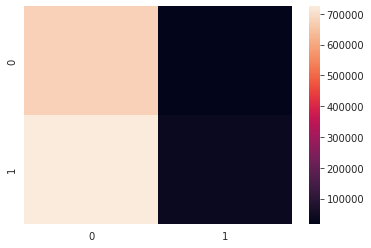

In [186]:
sns.heatmap(metrics.confusionMatrix().toArray())

### Regression model

We will try a gradient boost regression model

In [121]:
data_reg = data.drop("better_travel_type").dropna()
data_reg.show(1)

+----+-----+--------+------------+------------+-----------+---------------+----------+---------------+-----------+---------+--------+----------+---------+--------+-------------+
|year|month|time_bin|PULocationID|DOLocationID|day_of_week|trip_difference|peak_hours|weather_pattern|Temperature|Dew Point|Humidity|Wind Speed|Wind Gust|Pressure|Precipitation|
+----+-----+--------+------------+------------+-----------+---------------+----------+---------------+-----------+---------+--------+----------+---------+--------+-------------+
|2020|    7|       0|         113|          68|          4|           -206|         0|              1|       70.0|     65.0|    84.0|       6.0|      0.0|    29.9|          0.0|
+----+-----+--------+------------+------------+-----------+---------------+----------+---------------+-----------+---------+--------+----------+---------+--------+-------------+
only showing top 1 row



In [116]:
data_reg_processed = preprocessing_pipe(data_reg.dropna(), "trip_difference").dropna()
data_reg_processed.head(1)

[Row(year=2020, month=7, trip_difference=-206, peak_hours=0, Temperature=70.0, Dew Point=65.0, Humidity=84.0, Wind Speed=6.0, Wind Gust=0.0, Pressure=29.9, Precipitation=0.0, month_encoded=SparseVector(11, {5: 1.0}), time_bin_encoded=SparseVector(23, {22: 1.0}), PULocationID_encoded=SparseVector(59, {6: 1.0}), DOLocationID_encoded=SparseVector(59, {1: 1.0}), day_of_week_encoded=SparseVector(4, {2: 1.0}), weather_pattern_encoded=SparseVector(2, {1: 1.0}))]

In [118]:
data_reg.sample(0.0001, seed=69).show()

+----+-----+--------+------------+------------+-----------+---------------+----------+---------------+-----------+---------+--------+----------+---------+--------+-------------+
|year|month|time_bin|PULocationID|DOLocationID|day_of_week|trip_difference|peak_hours|weather_pattern|Temperature|Dew Point|Humidity|Wind Speed|Wind Gust|Pressure|Precipitation|
+----+-----+--------+------------+------------+-----------+---------------+----------+---------------+-----------+---------+--------+----------+---------+--------+-------------+
|2020|    7|      16|         249|          79|          4|           -169|         1|              1|       83.0|     59.0|    44.0|       8.0|      0.0|    29.8|          0.0|
|2020|    7|       9|          42|          41|          5|            539|         1|              1|       84.0|     70.0|    63.0|       6.0|      0.0|    30.0|          0.0|
|2020|    7|       8|         246|         164|          3|           -248|         1|              1|       7

In [120]:
data_reg_processed.sample(0.0001, seed=69).show()

+----+-----+---------------+----------+-----------+---------+--------+----------+---------+--------+-------------+--------------+----------------+--------------------+--------------------+-------------------+-----------------------+
|year|month|trip_difference|peak_hours|Temperature|Dew Point|Humidity|Wind Speed|Wind Gust|Pressure|Precipitation| month_encoded|time_bin_encoded|PULocationID_encoded|DOLocationID_encoded|day_of_week_encoded|weather_pattern_encoded|
+----+-----+---------------+----------+-----------+---------+--------+----------+---------+--------+-------------+--------------+----------------+--------------------+--------------------+-------------------+-----------------------+
|2020|    7|           -169|         1|       83.0|     59.0|    44.0|       8.0|      0.0|    29.8|          0.0|(11,[5],[1.0])|  (23,[3],[1.0])|      (59,[4],[1.0])|      (59,[0],[1.0])|      (4,[2],[1.0])|          (2,[1],[1.0])|
|2020|    7|            539|         1|       84.0|     70.0|    63.

In [61]:
X_test_reg = data_reg_processed.filter(col("year") == 2022).drop("year", "month").dropna()
X_val_reg = data_reg_processed.filter((col("year") == 2021) & (col("month") > 8)).drop("year", "month").dropna()
X_train_reg = data_reg_processed.filter((col("year") == 2020) | ((col("month") < 9) & (col("year") == 2021))).drop("year", "month").dropna()

X_train_reg.head(1)

[Row(trip_difference=-206, peak_hours=0, Temperature=70.0, Dew Point=65.0, Humidity=84.0, Wind Speed=6.0, Wind Gust=0.0, Pressure=29.9, Precipitation=0.0, month_encoded=SparseVector(11, {5: 1.0}), time_bin_encoded=SparseVector(23, {22: 1.0}), PULocationID_encoded=SparseVector(59, {6: 1.0}), DOLocationID_encoded=SparseVector(59, {1: 1.0}), day_of_week_encoded=SparseVector(4, {2: 1.0}), weather_pattern_encoded=SparseVector(2, {1: 1.0}))]

In [62]:
X_train_reg_processed = process_numerical(X_train_reg).dropna()
X_val_reg_processed = process_numerical(X_val_reg).dropna()
X_test_reg_processed = process_numerical(X_test_reg).dropna()

# Print data
X_train_reg_processed.head(1)

[Row(trip_difference=-206, peak_hours=0, month_encoded=SparseVector(11, {5: 1.0}), time_bin_encoded=SparseVector(23, {22: 1.0}), PULocationID_encoded=SparseVector(59, {6: 1.0}), DOLocationID_encoded=SparseVector(59, {1: 1.0}), day_of_week_encoded=SparseVector(4, {2: 1.0}), weather_pattern_encoded=SparseVector(2, {1: 1.0}), scaled=DenseVector([4.4218, 3.823, 4.8157, 1.1629, 0.0, 152.4391, 0.0]))]

In [63]:
X_train_reg_vector = vectorize(X_train_reg_processed, "trip_difference").dropna()
X_val_reg_vector = vectorize(X_val_reg_processed, "trip_difference").dropna()
X_test_reg_vector = vectorize(X_test_reg_processed, "trip_difference").dropna()

X_train_reg_vector.head(1)

[Row(label=-206, peak_hours=0, month_encoded=SparseVector(11, {5: 1.0}), time_bin_encoded=SparseVector(23, {22: 1.0}), PULocationID_encoded=SparseVector(59, {6: 1.0}), DOLocationID_encoded=SparseVector(59, {1: 1.0}), day_of_week_encoded=SparseVector(4, {2: 1.0}), weather_pattern_encoded=SparseVector(2, {1: 1.0}), scaled=DenseVector([4.4218, 3.823, 4.8157, 1.1629, 0.0, 152.4391, 0.0]), features=SparseVector(166, {6: 1.0, 34: 1.0, 41: 1.0, 95: 1.0, 155: 1.0, 158: 1.0, 159: 4.4218, 160: 3.823, 161: 4.8157, 162: 1.1629, 164: 152.4391}))]

In [64]:
# Scaling the dependent variable
X_train_reg_vector = X_train_reg_vector.withColumn("scaled_trip_difference", col("label") ** 3)

In [65]:
X_train_reg_vector.head()

Row(label=-206, peak_hours=0, month_encoded=SparseVector(11, {5: 1.0}), time_bin_encoded=SparseVector(23, {22: 1.0}), PULocationID_encoded=SparseVector(59, {6: 1.0}), DOLocationID_encoded=SparseVector(59, {1: 1.0}), day_of_week_encoded=SparseVector(4, {2: 1.0}), weather_pattern_encoded=SparseVector(2, {1: 1.0}), scaled=DenseVector([4.4218, 3.823, 4.8157, 1.1629, 0.0, 152.4391, 0.0]), features=SparseVector(166, {6: 1.0, 34: 1.0, 41: 1.0, 95: 1.0, 155: 1.0, 158: 1.0, 159: 4.4218, 160: 3.823, 161: 4.8157, 162: 1.1629, 164: 152.4391}), scaled_trip_difference=-8741816.0)

In [ ]:
gbtr = GBTRegressor(maxIter=20, maxDepth=8).fit(X_train_reg_vector.select("features", "label"))

In [85]:
gbtr_val_data = gbtr.transform(X_val_reg_vector.select("features", "label"))
gbtr_val_data.show(2)

+--------------------+-----+-------------------+
|            features|label|         prediction|
+--------------------+-----+-------------------+
|(166,[2,50,96,155...|  -12|-262.28636081509063|
|(166,[2,50,96,155...| -217|-262.28636081509063|
+--------------------+-----+-------------------+
only showing top 2 rows



In [86]:
rmse=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse=rmse.evaluate(gbtr_val_data)
rmse

607.6708953587029

In [87]:
gbtr_test_data = gbtr.transform(X_test_reg_vector.select("features", "label"))
gbtr_test_data.show(2)

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|(166,[11,34,60,11...|  136|-150.4190004661302|
|(166,[11,34,60,11...|  -78|-150.4190004661302|
+--------------------+-----+------------------+
only showing top 2 rows



In [89]:
rmse=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse=rmse.evaluate(gbtr_test_data)
rmse

569.3407713357003

In [97]:
r2=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2=r2.evaluate(gbtr_test_data)
r2

0.01619239306047837

In [76]:
X_train_reg_vector.select(variance("label")).show()

+-----------------+
|  var_samp(label)|
+-----------------+
|412039.8717451732|
+-----------------+



In [77]:
412039 ** 0.5

641.9026405927927

### Error Analysis Regression

In [105]:
gbtr_test_check = vectorize(process_numerical(preprocessing_pipe(data.drop("better_travel_type"), "trip_difference").filter(col("year") == 2022).drop("year").dropna()), "trip_difference")
gbtr_test_check.show(5)

+-----+-----+----------+---------------+----------------+--------------------+--------------------+-------------------+-----------------------+--------------------+--------------------+
|month|label|peak_hours|  month_encoded|time_bin_encoded|PULocationID_encoded|DOLocationID_encoded|day_of_week_encoded|weather_pattern_encoded|              scaled|            features|
+-----+-----+----------+---------------+----------------+--------------------+--------------------+-------------------+-----------------------+--------------------+--------------------+
|    1|  136|         0|(11,[10],[1.0])| (23,[22],[1.0])|     (59,[25],[1.0])|     (59,[19],[1.0])|          (4,[],[])|              (2,[],[])|[2.14232952149909...|(167,[0,12,35,61,...|
|    1|  -78|         0|(11,[10],[1.0])| (23,[22],[1.0])|     (59,[25],[1.0])|     (59,[19],[1.0])|          (4,[],[])|              (2,[],[])|[2.14232952149909...|(167,[0,12,35,61,...|
|    1|  163|         0|(11,[10],[1.0])|      (23,[],[])|     (59,[19]

In [106]:
gbtr_test_data_check = gbtr.transform(gbtr_test_check)
gbtr_test_data_check.show(2)

+-----+-----+----------+---------------+----------------+--------------------+--------------------+-------------------+-----------------------+--------------------+--------------------+-------------------+
|month|label|peak_hours|  month_encoded|time_bin_encoded|PULocationID_encoded|DOLocationID_encoded|day_of_week_encoded|weather_pattern_encoded|              scaled|            features|         prediction|
+-----+-----+----------+---------------+----------------+--------------------+--------------------+-------------------+-----------------------+--------------------+--------------------+-------------------+
|    1|  136|         0|(11,[10],[1.0])| (23,[22],[1.0])|     (59,[25],[1.0])|     (59,[19],[1.0])|          (4,[],[])|              (2,[],[])|[2.14232952149909...|(167,[0,12,35,61,...|-204.37093487945253|
|    1|  -78|         0|(11,[10],[1.0])| (23,[22],[1.0])|     (59,[25],[1.0])|     (59,[19],[1.0])|          (4,[],[])|              (2,[],[])|[2.14232952149909...|(167,[0,12,3

In [108]:
# Group by day_of_week
grouped_by_day = gbtr_test_data_check.groupBy("month", "day_of_week_encoded").avg("prediction", "label")
grouped_by_day.show()

+-----+-------------------+-------------------+-------------------+
|month|day_of_week_encoded|    avg(prediction)|         avg(label)|
+-----+-------------------+-------------------+-------------------+
|    2|      (4,[0],[1.0])|-151.04865172352444| 16.939003474207308|
|    1|          (4,[],[])|-176.28398100019933| -75.02613159122726|
|    3|      (4,[1],[1.0])|-132.14154736253562| -4.358509343175713|
|    3|      (4,[2],[1.0])| -128.2309345456129|-14.722505656833027|
|    4|      (4,[3],[1.0])|-179.55599716564217|-45.496558373404284|
|    1|      (4,[2],[1.0])|-175.35258685807452|-48.849989279843726|
|    4|      (4,[1],[1.0])|-159.95875603964285| -16.72636821237349|
|    2|      (4,[2],[1.0])|-164.88127610367494| -33.96961515581385|
|    2|      (4,[1],[1.0])|-162.53452723744675|-12.528437449389733|
|    4|      (4,[0],[1.0])| -146.0791664894322|-108.49346246973366|
|    2|      (4,[3],[1.0])| -168.8742751864257| -5.243718807319882|
|    3|      (4,[3],[1.0])|-136.18174458366602|-

In [109]:
error_pd = grouped_by_day.toPandas()

In [139]:
error_pd

,month,day_of_week_encoded,avg(prediction),avg(label)
0,2,"(1.0, 0.0, 0.0, 0.0)",-151.048652,16.939003
1,1,"(0.0, 0.0, 0.0, 0.0)",-176.283981,-75.026132
2,3,"(0.0, 1.0, 0.0, 0.0)",-132.141547,-4.358509
3,3,"(0.0, 0.0, 1.0, 0.0)",-128.230935,-14.722506
4,4,"(0.0, 0.0, 0.0, 1.0)",-179.555997,-45.496558
5,1,"(0.0, 0.0, 1.0, 0.0)",-175.352587,-48.849989
6,4,"(0.0, 1.0, 0.0, 0.0)",-159.958756,-16.726368
7,2,"(0.0, 0.0, 1.0, 0.0)",-164.881276,-33.969615
8,2,"(0.0, 1.0, 0.0, 0.0)",-162.534527,-12.528437
9,4,"(1.0, 0.0, 0.0, 0.0)",-146.079166,-108.493462


In [132]:
for index, row in error_pd.iterrows():
    print(row["day_of_week_encoded"].toArray())
    break

#matrix = RowMatrix(error_pd.select("day_of_week_encoded").rdd.map(lambda row: row.features))
#matrix

[1. 0. 0. 0.]


In [141]:
# 0 - 6 - Friday
# 1 - 5 - Thursday
# 2 - 4 - Wednesday
# 3 - 3 - Tuesday
# empty - Monday

"""days = []
    np.array([0.0, 0.0, 0.0, 0.0]) : "Monday",
    np.array([1.0, 0.0, 0.0, 0.0]) : "Friday",
    np.array([0.0, 1.0, 0.0, 0.0]) : "Thursday",
    np.array([0.0, 0.0, 1.0, 0.0]) : "Wednesday",
    np.array([0.0, 0.0, 0.0, 1.0]) :"Tuesday",
    ]"""

days_cols = []
for index, row in error_pd.iterrows():
    if (row["day_of_week_encoded"].toArray() == np.array([0.0, 0.0, 0.0, 0.0])).all():
        print(True)
        days_cols.append("Monday")
    elif(row["day_of_week_encoded"].toArray()  == np.array([1.0, 0.0, 0.0, 0.0])).all():
        days_cols.append("Friday")
    elif (row["day_of_week_encoded"].toArray()  == np.array([0.0, 1.0, 0.0, 0.0])).all():
        days_cols.append("Thursday")
    elif (row["day_of_week_encoded"].toArray()  == np.array([0.0, 0.0, 1.0, 0.0])).all():
        days_cols.append("Wednesday")
    elif (row["day_of_week_encoded"].toArray()  == np.array([0.0, 0.0, 0.0, 1.0])).all():
        days_cols.append("Tuesday")

#print(da)

error_pd["days"] = days_cols
error_pd.head()

True
True
True
True


,month,day_of_week_encoded,avg(prediction),avg(label),days
0,2,"(1.0, 0.0, 0.0, 0.0)",-151.048652,16.939003,Friday
1,1,"(0.0, 0.0, 0.0, 0.0)",-176.283981,-75.026132,Monday
2,3,"(0.0, 1.0, 0.0, 0.0)",-132.141547,-4.358509,Thursday
3,3,"(0.0, 0.0, 1.0, 0.0)",-128.230935,-14.722506,Wednesday
4,4,"(0.0, 0.0, 0.0, 1.0)",-179.555997,-45.496558,Tuesday


In [142]:
error_pd.isnull().any()

month                  False
day_of_week_encoded    False
avg(prediction)        False
avg(label)             False
days                   False
dtype: bool

<AxesSubplot:xlabel='days', ylabel='avg(prediction)'>

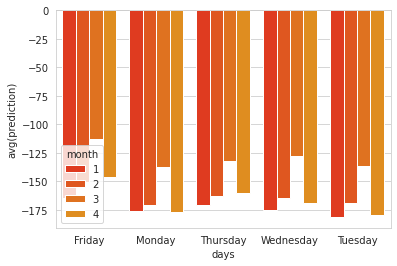

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("autumn")
sns.set_style("whitegrid")

sns.barplot(x="days", y="avg(prediction)", hue="month", data=error_pd)

In [173]:
prediction = error_pd.drop("avg(label)", axis=1)
prediction.columns = ["month",	"encoded",	"avg",	"days"]
prediction["hue"] = "Prediction"
label = error_pd.drop("avg(prediction)", axis=1)
label.columns = ["month",	"encoded",	"avg",	"days"]
label["hue"] = "Actual"

merged = pd.concat([prediction, label])
merged.head()

,month,encoded,avg,days,hue
0,2,"(1.0, 0.0, 0.0, 0.0)",-151.048652,Friday,Prediction
1,1,"(0.0, 0.0, 0.0, 0.0)",-176.283981,Monday,Prediction
2,3,"(0.0, 1.0, 0.0, 0.0)",-132.141547,Thursday,Prediction
3,3,"(0.0, 0.0, 1.0, 0.0)",-128.230935,Wednesday,Prediction
4,4,"(0.0, 0.0, 0.0, 1.0)",-179.555997,Tuesday,Prediction


<AxesSubplot:xlabel='days', ylabel='avg'>

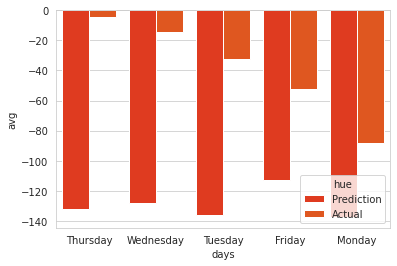

In [174]:
sns.barplot(x="days", y="avg", hue="hue", data=merged.drop("encoded", axis=1)[merged["month"] == 3])

In [175]:
merged_drop_3 = merged.drop("encoded", axis=1)[merged["month"] == 3]
merged_drop_3.head()

,month,avg,days,hue
2,3,-132.141547,Thursday,Prediction
3,3,-128.230935,Wednesday,Prediction
11,3,-136.181745,Tuesday,Prediction
13,3,-112.840583,Friday,Prediction
15,3,-137.745436,Monday,Prediction


In [176]:
merged_drop_3["avg"] = merged_drop_3["avg"].abs()

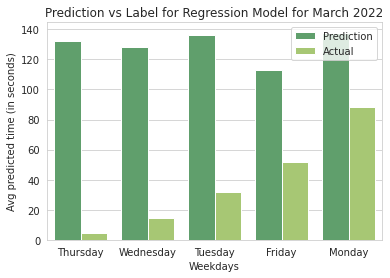

In [183]:
ax = sns.barplot(x="days", y="avg", hue="hue", data=merged_drop_3, palette="summer")
ax.legend_.set_title(None)

ax.set_title("Prediction vs Label for Regression Model for March 2022")
ax.set_xlabel("Weekdays")
ax.set_ylabel("Avg predicted time (in seconds)")

plt.show()

### Error Analysis Categorical